In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
import pywt
from typing import List, Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

In [2]:
class DWTAnomalyDetector:
    """
    Discrete Wavelet Transform based anomaly detector for time series data
    """
    
    def __init__(self, 
                 wavelet: str = 'db4',
                 levels: int = 4,
                 threshold_method: str = 'statistical',
                 contamination: float = 0.1):
        """
        Initialize DWT Anomaly Detector
        
        Args:
            wavelet: Type of wavelet to use ('db4', 'haar', 'db8', 'coif2', etc.)
            levels: Number of decomposition levels
            threshold_method: Method for anomaly detection ('statistical', 'isolation', 'clustering')
            contamination: Expected proportion of anomalies
        """
        self.wavelet = wavelet
        self.levels = levels
        self.threshold_method = threshold_method
        self.contamination = contamination
        self.scaler = StandardScaler()
        self.thresholds = {}
        self.is_fitted = False
        
    def dwt_decompose(self, signal_data: np.ndarray) -> Tuple[np.ndarray, List[np.ndarray]]:
        """
        Perform multi-level DWT decomposition
        
        Args:
            signal_data: Input time series signal
            
        Returns:
            approximation: Final approximation coefficients
            details: List of detail coefficients for each level
        """
        coeffs = pywt.wavedec(signal_data, self.wavelet, level=self.levels)
        
        # First coefficient is approximation, rest are details
        approximation = coeffs[0]
        details = coeffs[1:]
        
        return approximation, details
    
    def dwt_reconstruct(self, approximation: np.ndarray, details: List[np.ndarray]) -> np.ndarray:
        """
        Reconstruct signal from DWT coefficients
        
        Args:
            approximation: Approximation coefficients
            details: Detail coefficients
            
        Returns:
            reconstructed: Reconstructed signal
        """
        coeffs = [approximation] + details
        reconstructed = pywt.waverec(coeffs, self.wavelet)
        return reconstructed
    
    def extract_features(self, signal_data: np.ndarray) -> Dict[str, np.ndarray]:
        """
        Extract statistical features from DWT coefficients
        
        Args:
            signal_data: Input time series signal
            
        Returns:
            features: Dictionary of extracted features
        """
        approximation, details = self.dwt_decompose(signal_data)
        
        features = {}
        
        # Approximation features
        features['approx_energy'] = np.sum(approximation ** 2)
        features['approx_mean'] = np.mean(approximation)
        features['approx_std'] = np.std(approximation)
        features['approx_entropy'] = self._shannon_entropy(approximation)
        
        # Detail features for each level
        for i, detail in enumerate(details):
            level = i + 1
            features[f'detail_{level}_energy'] = np.sum(detail ** 2)
            features[f'detail_{level}_mean'] = np.mean(detail)
            features[f'detail_{level}_std'] = np.std(detail)
            features[f'detail_{level}_entropy'] = self._shannon_entropy(detail)
            features[f'detail_{level}_max'] = np.max(np.abs(detail))
            
            # High frequency activity indicators
            features[f'detail_{level}_spikes'] = np.sum(np.abs(detail) > 3 * np.std(detail))
            features[f'detail_{level}_zero_crossings'] = len(np.where(np.diff(np.sign(detail)))[0])
        
        # Energy distribution across levels
        total_energy = sum([np.sum(d**2) for d in details]) + np.sum(approximation**2)
        for i, detail in enumerate(details):
            level = i + 1
            features[f'detail_{level}_energy_ratio'] = np.sum(detail**2) / total_energy
        
        features['approx_energy_ratio'] = np.sum(approximation**2) / total_energy
        
        return features
    
    def _shannon_entropy(self, signal: np.ndarray) -> float:
        """Calculate Shannon entropy of a signal"""
        # Convert to probability distribution
        hist, _ = np.histogram(signal, bins=50, density=True)
        hist = hist[hist > 0]  # Remove zero probabilities
        entropy = -np.sum(hist * np.log2(hist + 1e-10))
        return entropy
    
    def sliding_window_features(self, signal_data: np.ndarray, 
                              window_size: int = 100, 
                              step_size: int = 10) -> Tuple[np.ndarray, np.ndarray]:
        """
        Extract DWT features using sliding window approach
        
        Args:
            signal_data: Input time series signal
            window_size: Size of sliding window
            step_size: Step size for sliding window
            
        Returns:
            feature_matrix: Matrix of extracted features
            window_centers: Center indices of each window
        """
        features_list = []
        window_centers = []
        
        for start in range(0, len(signal_data) - window_size + 1, step_size):
            end = start + window_size
            window_data = signal_data[start:end]
            
            # Extract features for this window
            window_features = self.extract_features(window_data)
            features_list.append(list(window_features.values()))
            window_centers.append(start + window_size // 2)
        
        feature_matrix = np.array(features_list)
        window_centers = np.array(window_centers)
        
        return feature_matrix, window_centers
    
    def detect_anomalies_statistical(self, features: np.ndarray) -> np.ndarray:
        """
        Detect anomalies using statistical thresholding (Z-score based)
        """
        # Normalize features
        features_normalized = self.scaler.fit_transform(features)
        
        # Calculate Z-scores
        z_scores = np.abs(zscore(features_normalized, axis=0))
        
        # Aggregate Z-scores (max across features for each sample)
        anomaly_scores = np.max(z_scores, axis=1)
        
        # Set threshold based on contamination rate
        threshold = np.percentile(anomaly_scores, (1 - self.contamination) * 100)
        self.thresholds['statistical'] = threshold
        
        return anomaly_scores
    
    def detect_anomalies_isolation(self, features: np.ndarray) -> np.ndarray:
        """
        Detect anomalies using Isolation Forest
        """
        # Normalize features
        features_normalized = self.scaler.fit_transform(features)
        
        # Fit Isolation Forest
        iso_forest = IsolationForest(contamination=self.contamination, random_state=42)
        iso_forest.fit(features_normalized)
        
        # Get anomaly scores (negative values indicate anomalies)
        anomaly_scores = -iso_forest.decision_function(features_normalized)
        
        # Store the model for future use
        self.isolation_model = iso_forest
        
        return anomaly_scores
    
    def detect_anomalies_clustering(self, features: np.ndarray) -> np.ndarray:
        """
        Detect anomalies using DBSCAN clustering
        """
        # Normalize features
        features_normalized = self.scaler.fit_transform(features)
        
        # Apply DBSCAN
        eps = np.percentile(np.pdist(features_normalized), 5)  # Adaptive eps
        dbscan = DBSCAN(eps=eps, min_samples=5)
        clusters = dbscan.fit_predict(features_normalized)
        
        # Points labeled as -1 are anomalies
        anomaly_scores = np.where(clusters == -1, 1.0, 0.0)
        
        # For non-anomalies, calculate distance to cluster center
        for cluster_id in np.unique(clusters):
            if cluster_id != -1:
                cluster_mask = clusters == cluster_id
                cluster_center = np.mean(features_normalized[cluster_mask], axis=0)
                distances = np.linalg.norm(
                    features_normalized[cluster_mask] - cluster_center, axis=1
                )
                anomaly_scores[cluster_mask] = distances / np.max(distances)
        
        return anomaly_scores
    
    def fit(self, signal_data: np.ndarray, window_size: int = 100, step_size: int = 10):
        """
        Fit the anomaly detector on training data
        
        Args:
            signal_data: Training time series data
            window_size: Size of sliding window
            step_size: Step size for sliding window
        """
        # Extract features using sliding window
        features, _ = self.sliding_window_features(signal_data, window_size, step_size)
        
        # Store parameters
        self.window_size = window_size
        self.step_size = step_size
        
        # Fit based on selected method
        if self.threshold_method == 'statistical':
            self.detect_anomalies_statistical(features)
        elif self.threshold_method == 'isolation':
            self.detect_anomalies_isolation(features)
        elif self.threshold_method == 'clustering':
            self.detect_anomalies_clustering(features)
        
        self.is_fitted = True
        
    def predict(self, signal_data: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Predict anomalies in new data
        
        Args:
            signal_data: Input time series data
            
        Returns:
            anomaly_scores: Anomaly scores for each window
            window_centers: Center indices of each window
            predictions: Binary predictions (1 for anomaly, 0 for normal)
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted before prediction")
        
        # Extract features
        features, window_centers = self.sliding_window_features(
            signal_data, self.window_size, self.step_size
        )
        
        # Get anomaly scores based on method
        if self.threshold_method == 'statistical':
            features_normalized = self.scaler.transform(features)
            z_scores = np.abs(zscore(features_normalized, axis=0))
            anomaly_scores = np.max(z_scores, axis=1)
            predictions = (anomaly_scores > self.thresholds['statistical']).astype(int)
            
        elif self.threshold_method == 'isolation':
            features_normalized = self.scaler.transform(features)
            anomaly_scores = -self.isolation_model.decision_function(features_normalized)
            predictions = self.isolation_model.predict(features_normalized)
            predictions = (predictions == -1).astype(int)
            
        elif self.threshold_method == 'clustering':
            anomaly_scores = self.detect_anomalies_clustering(features)
            predictions = (anomaly_scores > 0.5).astype(int)
        
        return anomaly_scores, window_centers, predictions

In [3]:
class DWTAnomalyAnalyzer:
    """
    Comprehensive analyzer for DWT-based anomaly detection
    """
    
    def __init__(self):
        self.detectors = {}
        self.results = {}
    
    def compare_wavelets(self, signal_data: np.ndarray, labels: np.ndarray = None,
                        wavelets: List[str] = ['db4', 'haar', 'db8', 'coif2', 'bior2.2']):
        """
        Compare different wavelet types for anomaly detection
        """
        results = {}
        
        for wavelet in wavelets:
            print(f"Testing wavelet: {wavelet}")
            
            try:
                detector = DWTAnomalyDetector(wavelet=wavelet, threshold_method='isolation')
                
                # Split data for training/testing
                split_idx = int(len(signal_data) * 0.7)
                train_data = signal_data[:split_idx]
                test_data = signal_data[split_idx:]
                
                # Fit and predict
                detector.fit(train_data)
                scores, centers, predictions = detector.predict(test_data)
                
                # Calculate metrics if labels are available
                if labels is not None:
                    test_labels = labels[split_idx:]
                    # Map window centers to labels
                    window_labels = []
                    for center in centers:
                        if center < len(test_labels):
                            window_labels.append(test_labels[center])
                        else:
                            window_labels.append(0)
                    
                    window_labels = np.array(window_labels)
                    auc = roc_auc_score(window_labels, scores) if len(np.unique(window_labels)) > 1 else 0
                else:
                    auc = None
                
                results[wavelet] = {
                    'detector': detector,
                    'scores': scores,
                    'predictions': predictions,
                    'auc': auc
                }
                
            except Exception as e:
                print(f"Error with wavelet {wavelet}: {e}")
                continue
        
        self.results = results
        return results
    
    def plot_dwt_decomposition(self, signal_data: np.ndarray, wavelet: str = 'db4', 
                              levels: int = 4, title: str = "DWT Decomposition"):
        """
        Visualize DWT decomposition
        """
        detector = DWTAnomalyDetector(wavelet=wavelet, levels=levels)
        approximation, details = detector.dwt_decompose(signal_data)
        
        fig, axes = plt.subplots(levels + 2, 1, figsize=(15, 12))
        
        # Original signal
        axes[0].plot(signal_data)
        axes[0].set_title(f'{title} - Original Signal')
        axes[0].grid(True)
        
        # Approximation
        axes[1].plot(approximation)
        axes[1].set_title(f'Approximation (Level {levels})')
        axes[1].grid(True)
        
        # Details
        for i, detail in enumerate(details):
            axes[i + 2].plot(detail)
            axes[i + 2].set_title(f'Detail Level {i + 1}')
            axes[i + 2].grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def plot_anomaly_results(self, signal_data: np.ndarray, detector: DWTAnomalyDetector,
                           labels: np.ndarray = None, title: str = "Anomaly Detection Results"):
        """
        Plot comprehensive anomaly detection results
        """
        # Get predictions
        scores, centers, predictions = detector.predict(signal_data)
        
        fig, axes = plt.subplots(3, 2, figsize=(20, 15))
        
        # Original signal with anomalies marked
        axes[0, 0].plot(signal_data, alpha=0.7, label='Signal')
        if labels is not None:
            anomaly_indices = np.where(labels == 1)[0]
            axes[0, 0].scatter(anomaly_indices, signal_data[anomaly_indices], 
                             color='red', alpha=0.6, s=10, label='True Anomalies')
        
        # Mark detected anomalies
        anomaly_centers = centers[predictions == 1]
        if len(anomaly_centers) > 0:
            axes[0, 0].scatter(anomaly_centers, signal_data[anomaly_centers], 
                             color='orange', alpha=0.8, s=30, marker='x', 
                             label='Detected Anomalies')
        
        axes[0, 0].set_title(f'{title} - Signal with Anomalies')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # Anomaly scores
        axes[0, 1].plot(centers, scores)
        axes[0, 1].set_title('Anomaly Scores')
        axes[0, 1].set_xlabel('Time')
        axes[0, 1].set_ylabel('Score')
        axes[0, 1].grid(True)
        
        # DWT decomposition visualization
        approximation, details = detector.dwt_decompose(signal_data)
        
        # Approximation
        axes[1, 0].plot(approximation)
        axes[1, 0].set_title('Approximation Coefficients')
        axes[1, 0].grid(True)
        
        # Energy distribution
        total_energy = sum([np.sum(d**2) for d in details]) + np.sum(approximation**2)
        energy_ratios = [np.sum(d**2)/total_energy for d in details]
        energy_ratios.append(np.sum(approximation**2)/total_energy)
        
        level_names = [f'D{i+1}' for i in range(len(details))] + ['A']
        axes[1, 1].bar(level_names, energy_ratios)
        axes[1, 1].set_title('Energy Distribution Across Levels')
        axes[1, 1].set_ylabel('Energy Ratio')
        axes[1, 1].grid(True)
        
        # Detail coefficients (first few levels)
        for i in range(min(2, len(details))):
            axes[2, i].plot(details[i])
            axes[2, i].set_title(f'Detail Level {i+1}')
            axes[2, i].grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Performance metrics if labels available
        if labels is not None:
            window_labels = []
            for center in centers:
                if center < len(labels):
                    window_labels.append(labels[center])
                else:
                    window_labels.append(0)
            
            window_labels = np.array(window_labels)
            
            if len(np.unique(window_labels)) > 1:
                auc = roc_auc_score(window_labels, scores)
                print(f"\nPerformance Metrics:")
                print(f"AUC Score: {auc:.4f}")
                print("\nClassification Report:")
                print(classification_report(window_labels, predictions))
                
                # ROC Curve
                fpr, tpr, _ = roc_curve(window_labels, scores)
                plt.figure(figsize=(8, 6))
                plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
                plt.plot([0, 1], [0, 1], 'k--', label='Random')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title('ROC Curve')
                plt.legend()
                plt.grid(True)
                plt.show()

In [4]:
def main():
    """
    Main demonstration function
    """
    print("DWT-based Time Series Anomaly Detection Demo")
    print("=" * 50)

    data = pd.read_csv("AGC_Data.csv")
    signal_data = data['speed'].values
    labels = data['pred_label'].values
    
    print(f"Data shape: {signal_data.shape}")
    print(f"Anomaly ratio: {labels.mean():.3f}")
    
    # Initialize analyzer
    analyzer = DWTAnomalyAnalyzer()
    
    # Plot DWT decomposition
    print("\nVisualizing DWT decomposition...")
    analyzer.plot_dwt_decomposition(signal_data, wavelet='db4', levels=4)
    
    # Test single detector
    print("\nTesting single DWT detector...")
    detector = DWTAnomalyDetector(
        wavelet='db4',
        levels=4,
        threshold_method='isolation',
        contamination=0.1
    )
    
    # Split data for training/testing
    split_idx = int(len(signal_data) * 0.7)
    train_data = signal_data[:split_idx]
    test_data = signal_data[split_idx:]
    test_labels = labels[split_idx:]
    
    # Fit and predict
    print("Fitting detector...")
    detector.fit(train_data, window_size=100, step_size=20)
    
    print("Making predictions...")
    scores, centers, predictions = detector.predict(test_data)
    
    # Plot results
    print("Plotting results...")
    analyzer.plot_anomaly_results(test_data, detector, test_labels, 
                                 title="DWT Anomaly Detection")
    
    # Compare different wavelets
    print("\nComparing different wavelets...")
    wavelet_results = analyzer.compare_wavelets(
        signal_data, labels, 
        wavelets=['db4', 'haar', 'db8', 'coif2', 'bior2.2']
    )
    
    # Print comparison results
    print("\nWavelet Comparison Results:")
    print("-" * 40)
    for wavelet, result in wavelet_results.items():
        if result['auc'] is not None:
            print(f"{wavelet:10}: AUC = {result['auc']:.4f}")
        else:
            print(f"{wavelet:10}: No evaluation possible")
    
    return detector, analyzer

DWT-based Time Series Anomaly Detection Demo
Data shape: (100000,)
Anomaly ratio: 0.043

Visualizing DWT decomposition...


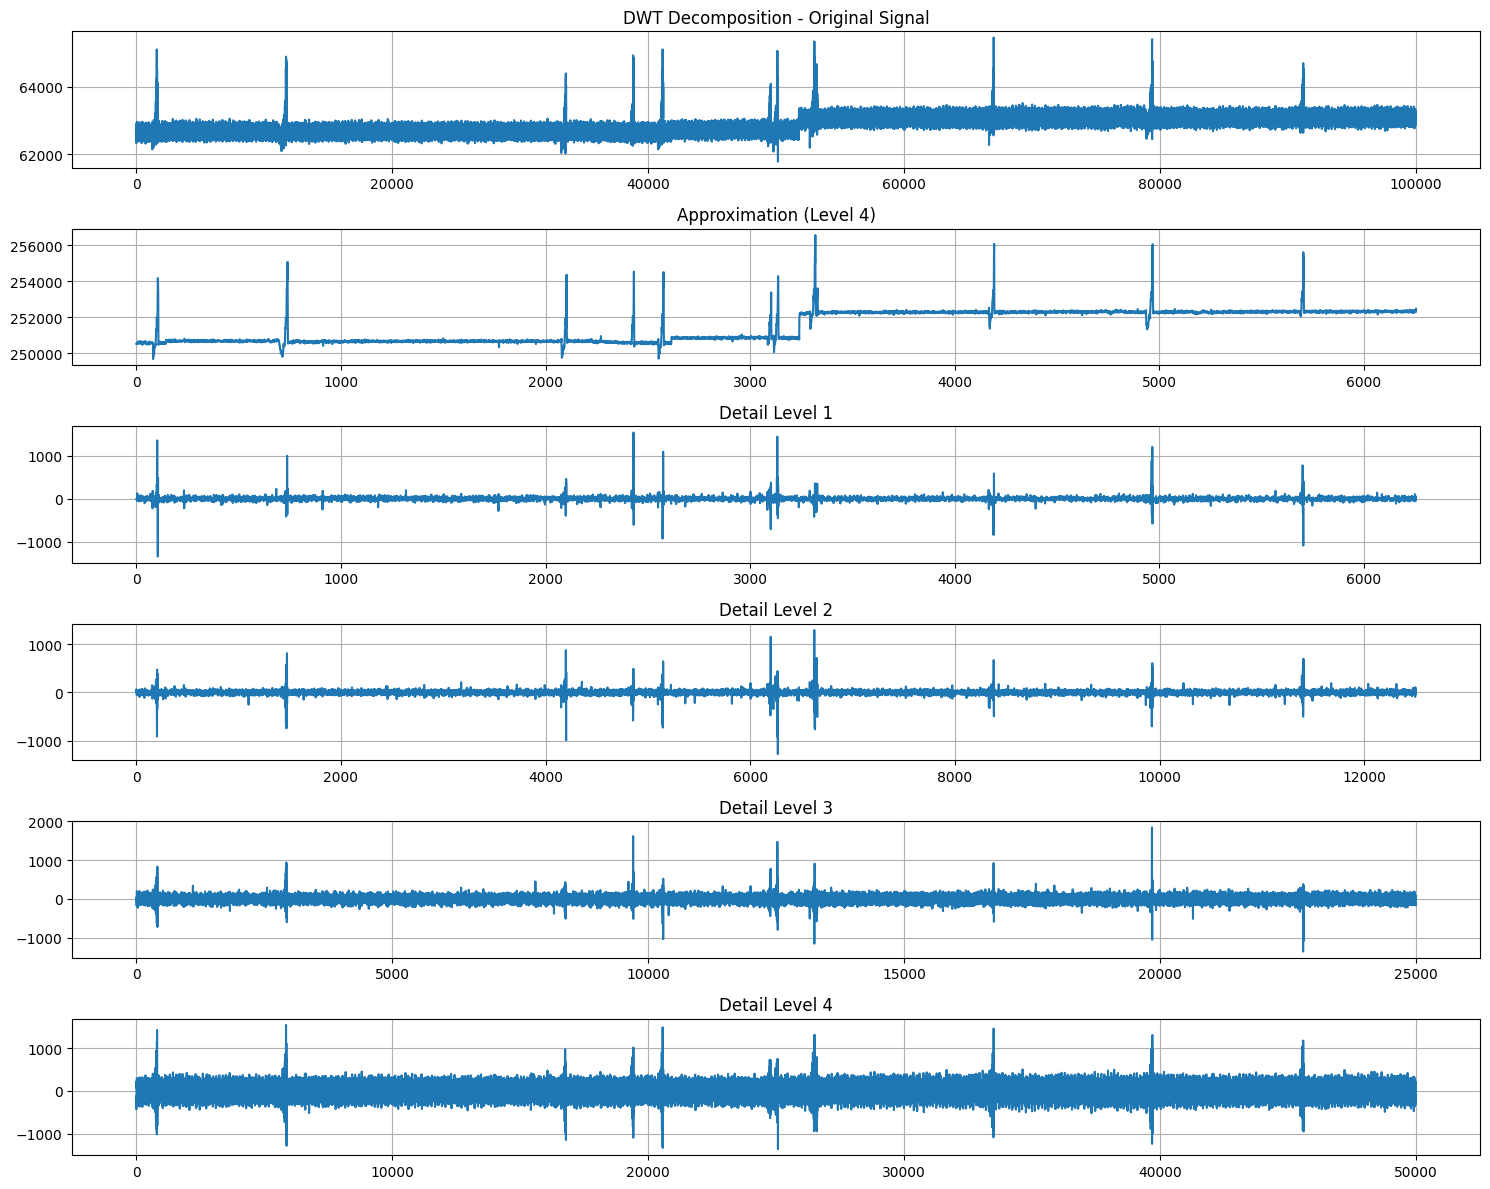


Testing single DWT detector...
Fitting detector...
Making predictions...
Plotting results...


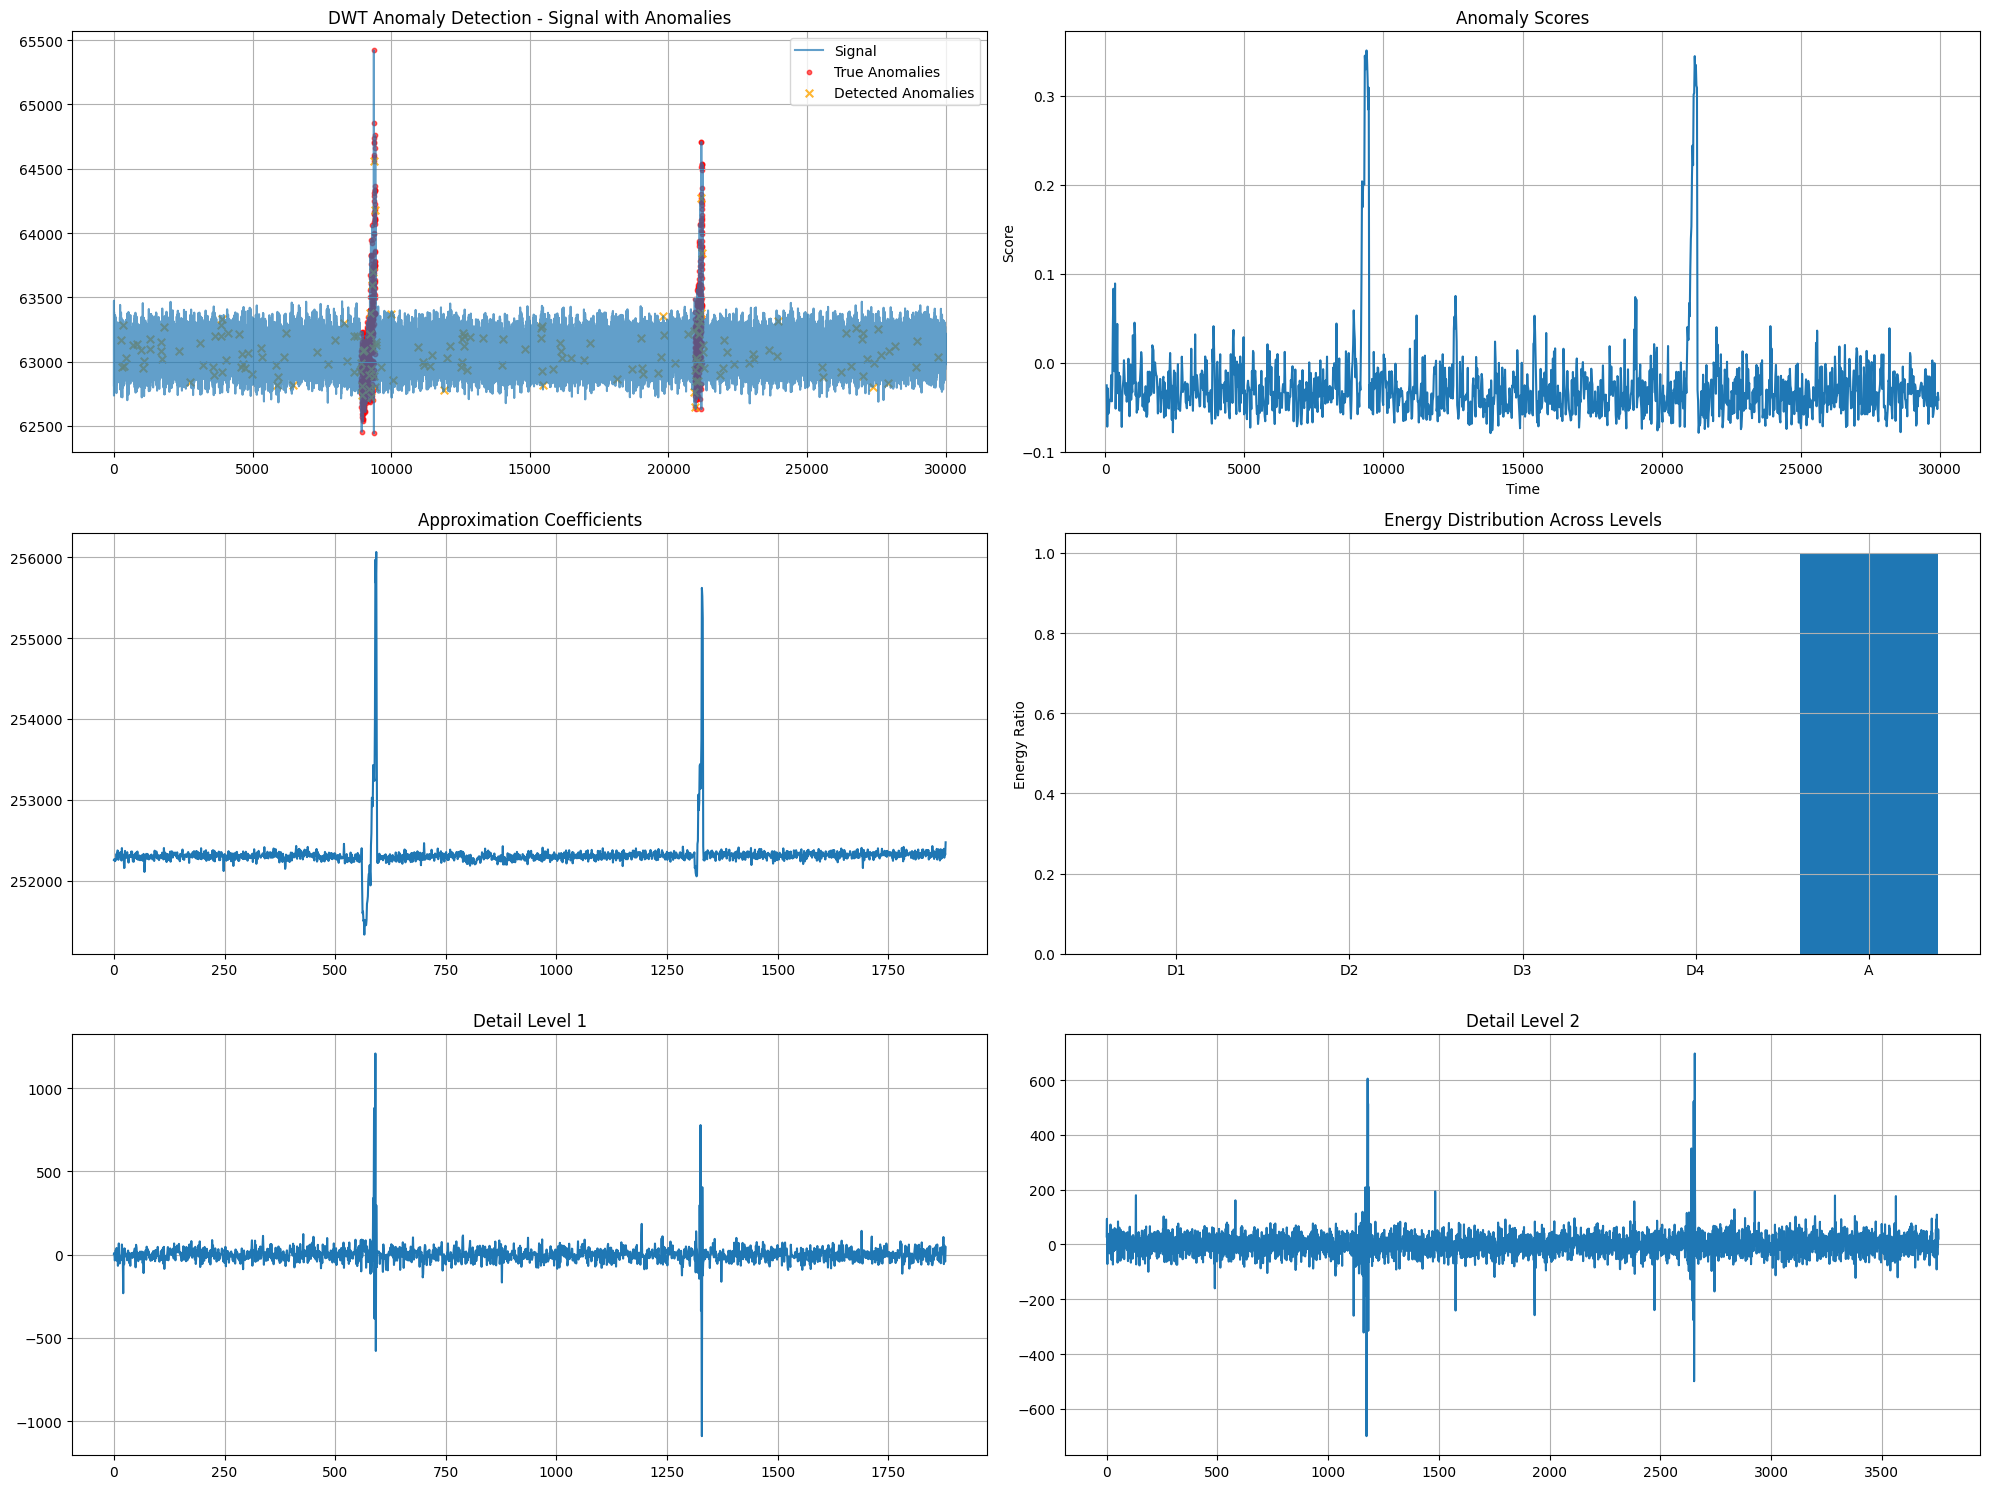


Performance Metrics:
AUC Score: 0.8909

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1455
           1       0.19      0.78      0.30        41

    accuracy                           0.90      1496
   macro avg       0.59      0.84      0.63      1496
weighted avg       0.97      0.90      0.93      1496



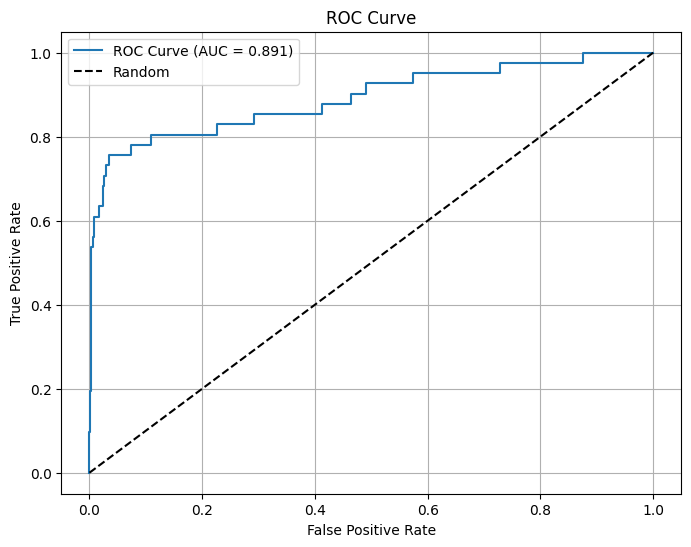


Comparing different wavelets...
Testing wavelet: db4
Testing wavelet: haar
Testing wavelet: db8
Testing wavelet: coif2
Testing wavelet: bior2.2

Wavelet Comparison Results:
----------------------------------------
db4       : AUC = 0.9016
haar      : AUC = 0.9576
db8       : AUC = 0.9424
coif2     : AUC = 0.9478
bior2.2   : AUC = 0.9242


In [5]:
if __name__ == "__main__":
    detector, analyzer = main()